# Regular Genomics Project **RNA Localisation**


In [1]:
from plotting import plot_line_graph, multiplot_pearson
from metrics import Pearson
from models import CNN
from utils import prepare_data, set_variables
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [2]:
train_data, valid_data, test_data = prepare_data()

### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [5]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
model_name = 'attention_base'
model_architecture_path, model_output_path, params_dataLoader_train, params_dataLoader_valid, params_model, params_train = set_variables(model_name, max_seq_len)

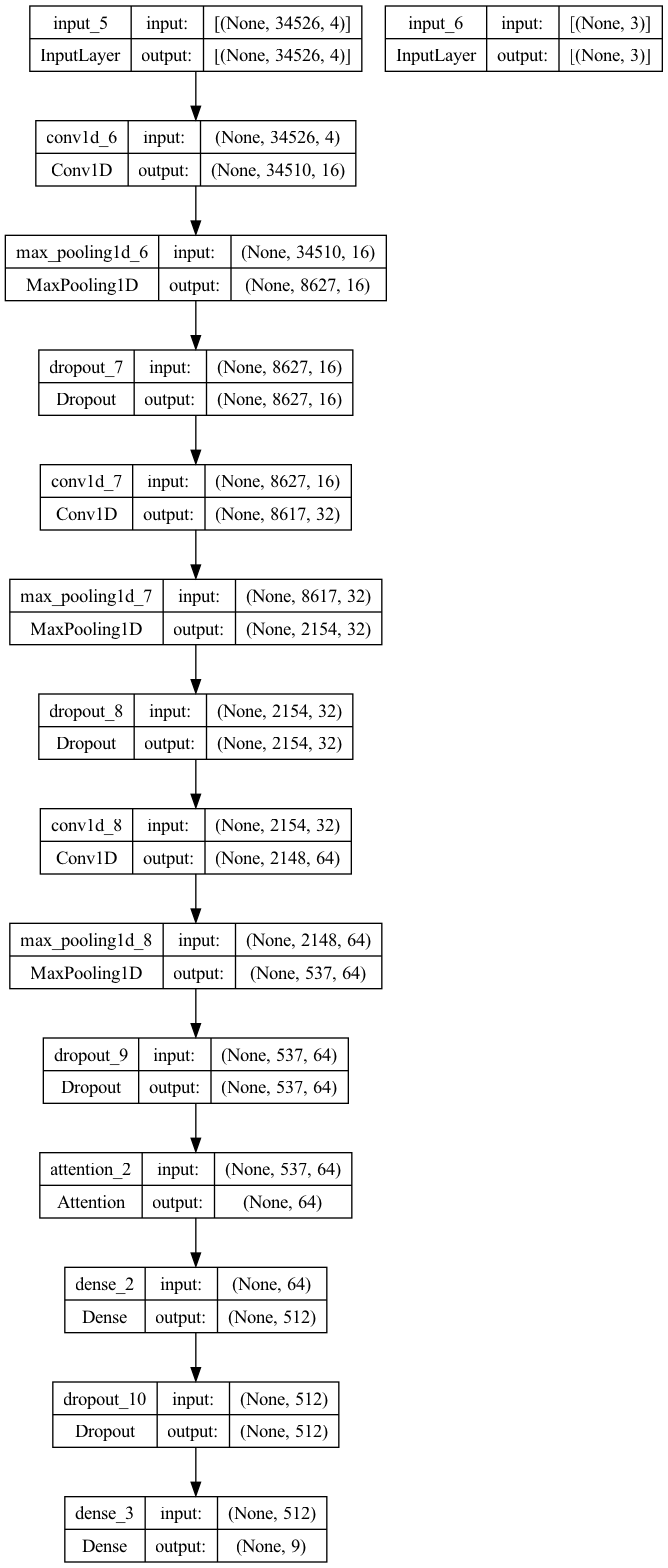

In [10]:
model = CNN(input_size=(max_seq_len, 4),
            params_model=params_model,
            metrics=[Pearson(return_dict=True)]
            )

model.print_model()
# model.summary() #if information about number of params needed

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 34526, 4)]           0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 34510, 16)            1104      ['input_5[0][0]']             
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 8627, 16)             0         ['conv1d_6[0][0]']            
 g1D)                                                                                             
                                                                                                  
 dropout_7 (Dropout)         (None, 8627, 16)             0         ['max_pooling1d_6[0][0]'

In [12]:
history = model.fit_and_evaluate(train_data=train_data, eval_data=valid_data,
                                 params_train_dataLoader=params_dataLoader_train,
                                 params_eval_dataLoader=params_dataLoader_valid,
                                 params_train=params_train,
                                 callback=[EarlyStopping(monitor='loss', patience=2)])

Epoch 1/50
311/311 [==============================] - 45s 142ms/step - loss: 2.3284 - ERM: 0.1143 - KDEL: 0.1099 - LMA: 0.0035 - MITO: 0.1150 - NES: 0.0067 - NIK: 0.0122 - NLS: 0.0193 - NUCP: 0.0331 - OMM: 0.0355 - val_loss: 2.1792 - val_ERM: 0.1044 - val_KDEL: 0.1256 - val_LMA: -0.0421 - val_MITO: 0.0802 - val_NES: 0.1491 - val_NIK: -0.1240 - val_NLS: 0.0282 - val_NUCP: 0.0776 - val_OMM: 0.0480
Epoch 2/50
311/311 [==============================] - 44s 141ms/step - loss: 2.1734 - ERM: 0.2025 - KDEL: 0.2518 - LMA: 0.0069 - MITO: 0.1119 - NES: 0.0384 - NIK: 0.0587 - NLS: 0.0434 - NUCP: 0.1016 - OMM: 0.0482 - val_loss: 2.1808 - val_ERM: 0.1033 - val_KDEL: 0.1792 - val_LMA: 0.0304 - val_MITO: 0.0284 - val_NES: 0.0797 - val_NIK: 0.0302 - val_NLS: 0.1347 - val_NUCP: 0.0744 - val_OMM: 0.0701
Epoch 3/50
311/311 [==============================] - 44s 142ms/step - loss: 2.1708 - ERM: 0.2527 - KDEL: 0.2920 - LMA: 0.0491 - MITO: 0.1118 - NES: 0.0726 - NIK: 0.0923 - NLS: 0.0665 - NUCP: 0.1395 - OMM

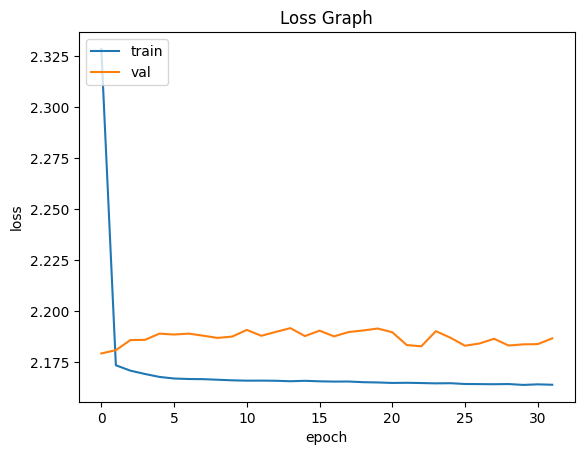

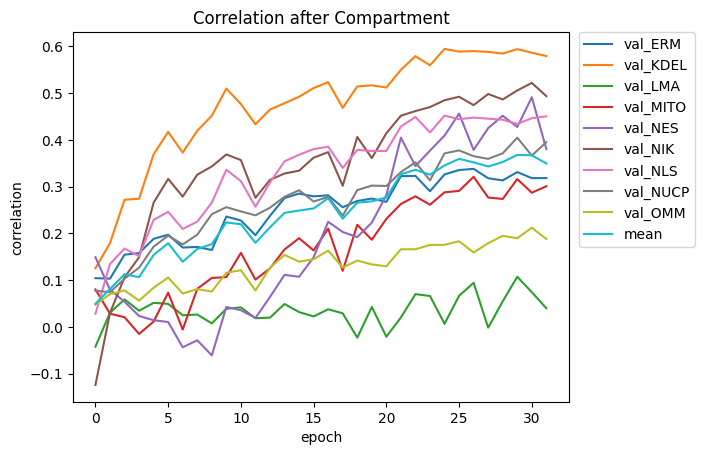

In [13]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

multiplot_pearson(history.history)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

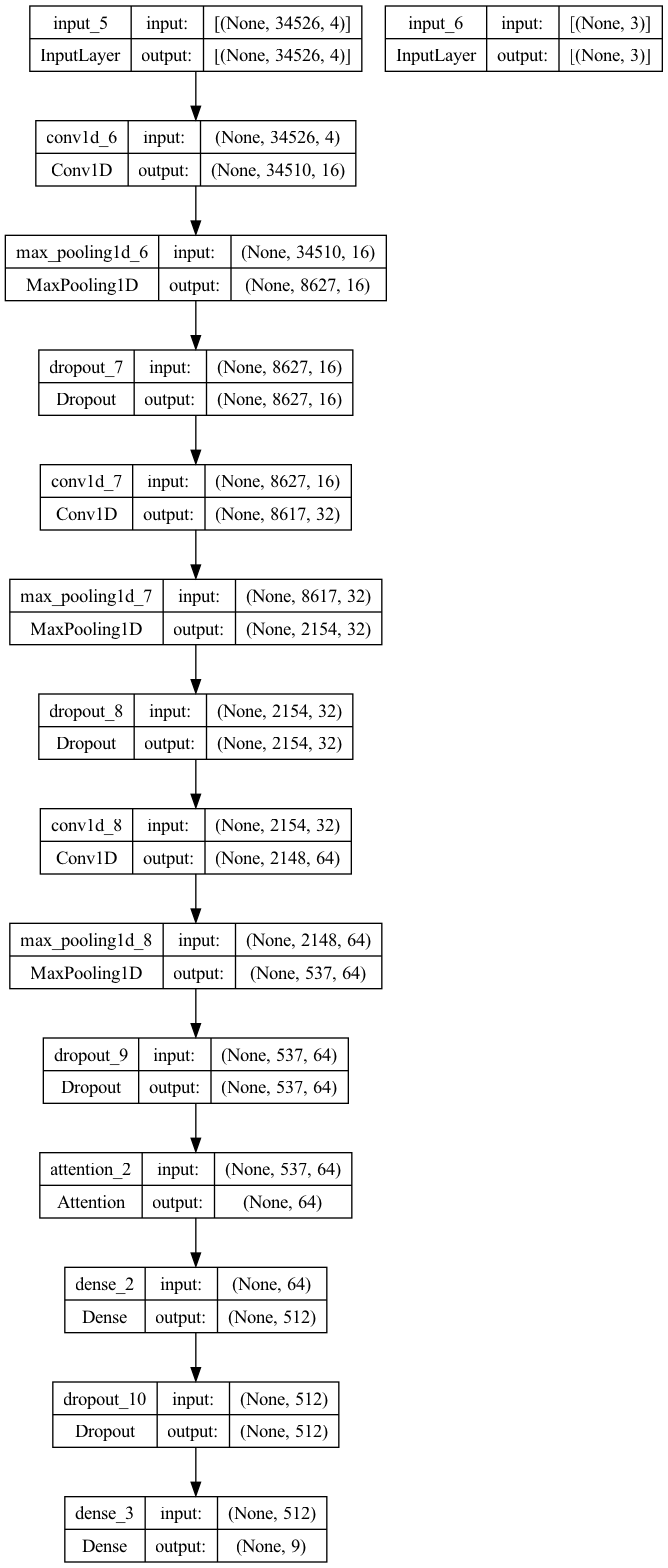

In [14]:
model.print_model(model_architecture_path)
#model.save_model(model_output_path)

In [15]:
model.save_model(model_output_path)

In [17]:
from dataloaders import GeneDataLoader
import numpy as np
import tensorflow_probability as tfp

dataloader = GeneDataLoader(test_data, padding_length=train_data['seq'].apply(lambda x: len(x)).max(), shuffle=False, struct=False)

prediction = []
y_test = []

for i, j in dataloader:
    prediction.append(model.model.predict(i))
    y_test.append(j)

prediction = np.concatenate(prediction)
y_test = np.concatenate(y_test)
def pearson_dict(y_true, y_pred):
    y_true_std = tfp.stats.stddev(y_true, sample_axis=0, keepdims=True)
    y_pred_std = tfp.stats.stddev(y_pred, sample_axis=0, keepdims=True)
    
    y_true /= (y_true_std + 1e-3)
    y_pred /= (y_pred_std + 1e-3)
    
    result = tfp.stats.covariance(x=y_true,
                                y=y_pred,
                                event_axis=None,
                                sample_axis=0,
                                keepdims=False)
    res_dict = {}
    res_dict['ERM'] = result[0]
    res_dict['KDEL'] = result[1]
    res_dict['LMA'] = result[2]
    res_dict['MITO'] = result[3]
    res_dict['NES'] = result[4]
    res_dict['NIK'] = result[5]
    res_dict['NLS'] = result[6]
    res_dict['NUCP'] = result[7]
    res_dict['OMM'] = result[8]
    return res_dict

1/1 [==============================] - 0s 72ms/step


In [18]:
pearson_dict(y_test, prediction)

{'ERM': <tf.Tensor: shape=(), dtype=float32, numpy=0.28228608>,
 'KDEL': <tf.Tensor: shape=(), dtype=float32, numpy=0.30171472>,
 'LMA': <tf.Tensor: shape=(), dtype=float32, numpy=0.04218219>,
 'MITO': <tf.Tensor: shape=(), dtype=float32, numpy=0.119830266>,
 'NES': <tf.Tensor: shape=(), dtype=float32, numpy=0.10374282>,
 'NIK': <tf.Tensor: shape=(), dtype=float32, numpy=0.18235296>,
 'NLS': <tf.Tensor: shape=(), dtype=float32, numpy=0.18389148>,
 'NUCP': <tf.Tensor: shape=(), dtype=float32, numpy=0.20517074>,
 'OMM': <tf.Tensor: shape=(), dtype=float32, numpy=0.09971723>}

In [19]:
np.mean(list(pearson_dict(y_test, prediction).values()))

0.16898762